## descriptive data exploration
* study the trending of correlation

### feature ranking
* correlation btw each feature and unit price
* random forest ranking


In [89]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
ds.update_views()

connect to database postgresql://postgres:@localhost:5432/sdra
['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions']
execute  c:\wenyan\dse_capstone\database\preprocess.sql


In [104]:
df_view = ds.get_view_df('property_address_transactions')
print(df_view.shape)
pp = Preprocess(df_view)
df_all = pp.dataset()

(1449003, 16)
converting view
converting pool
converting date
Index(['sqft', 'view', 'pool', 'year_built', 'num_bed', 'date', 'sqft_price',
       'num_bath'],
      dtype='object')
converting sold_year
converting sold_age


### yearly trending of feature correlation

In [105]:
df_all_valid = df_all[(df_all['sqft_price']<1000)
                    #&(df_all['year_built'] > 0)
                    ]
df_all_valid.shape

(1446136, 10)

In [106]:
# last year transactions of valid properties
df_last_year = df_all_valid[(df_all_valid['date'] >= '2016-10-01') & (df_all_valid['date'] < '2017-10-01')]
df_last_year.shape

(37558, 10)

### price/unit price correlation
* with geography: street, zip, city
* with transaction#
* with property characteristic: sqft, lot_size_sqft

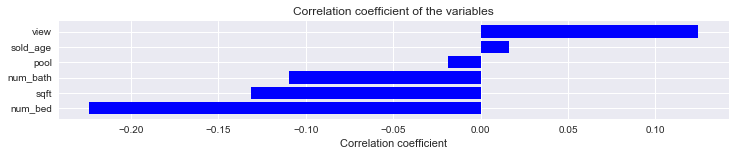

In [107]:
features = set(df_last_year.columns) - set(['date', 'year_built', 'sold_year', 'sqft_price'])
df_corr_unit_price = plot_correlation(df_last_year, 'sqft_price', features)

In [108]:
year_begin, year_end = df_all_valid['sold_year'].min(), df_all_valid['sold_year'].max()

In [109]:
corrs = []
for year in range(year_begin, year_end+1):
    df_year = df_all_valid[df_all_valid['sold_year']==year]
    print(year, df_year.shape[0])
    corr = plot_correlation(df_year, 'sqft_price', features, False)
    corr['year'] = year
    corrs.append(corr)

1983 (31605, 10)
1984 (37325, 10)
1985 (42592, 10)
1986 (50963, 10)
1987 (51113, 10)
1988 (58159, 10)
1989 (53658, 10)
1990 (39024, 10)
1991 (32136, 10)
1992 (30867, 10)
1993 (30723, 10)
1994 (33698, 10)
1995 (28589, 10)
1996 (33196, 10)
1997 (39532, 10)
1998 (48895, 10)
1999 (52552, 10)
2000 (50883, 10)
2001 (48944, 10)
2002 (55076, 10)
2003 (58822, 10)
2004 (61545, 10)
2005 (55906, 10)
2006 (40286, 10)
2007 (30699, 10)
2008 (31699, 10)
2009 (36514, 10)
2010 (34284, 10)
2011 (33209, 10)
2012 (37897, 10)
2013 (39542, 10)
2014 (31069, 10)
2015 (37771, 10)
2016 (39159, 10)
2017 (28204, 10)


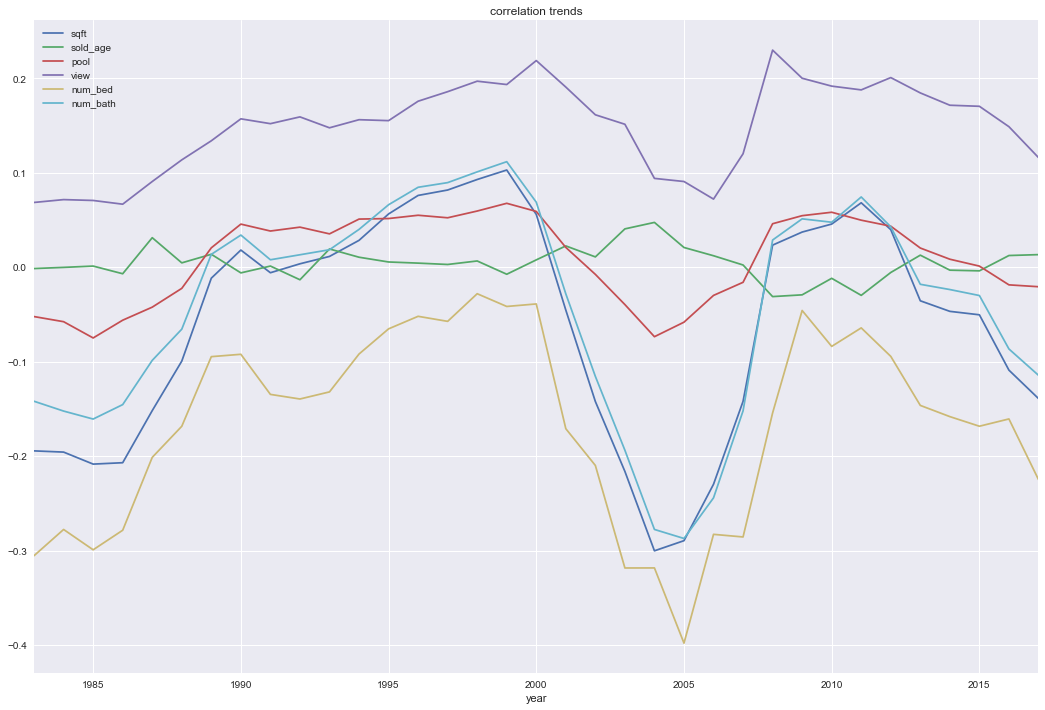

In [110]:
df_corr_all = pd.DataFrame(corrs).set_index(['year'])
plot_trends(df_corr_all, features, 'correlation trends')

### sqft price trend per brackets on features
* Features used for bracket method: sqft, sold_age, dist_to_coast
* bracket method
  * segment continuous numeric feature into brackets based on quantile
  * Compute the average sqft price for each bracket on each year
  * Cluster the brackets based on their sqft price yearly sequence

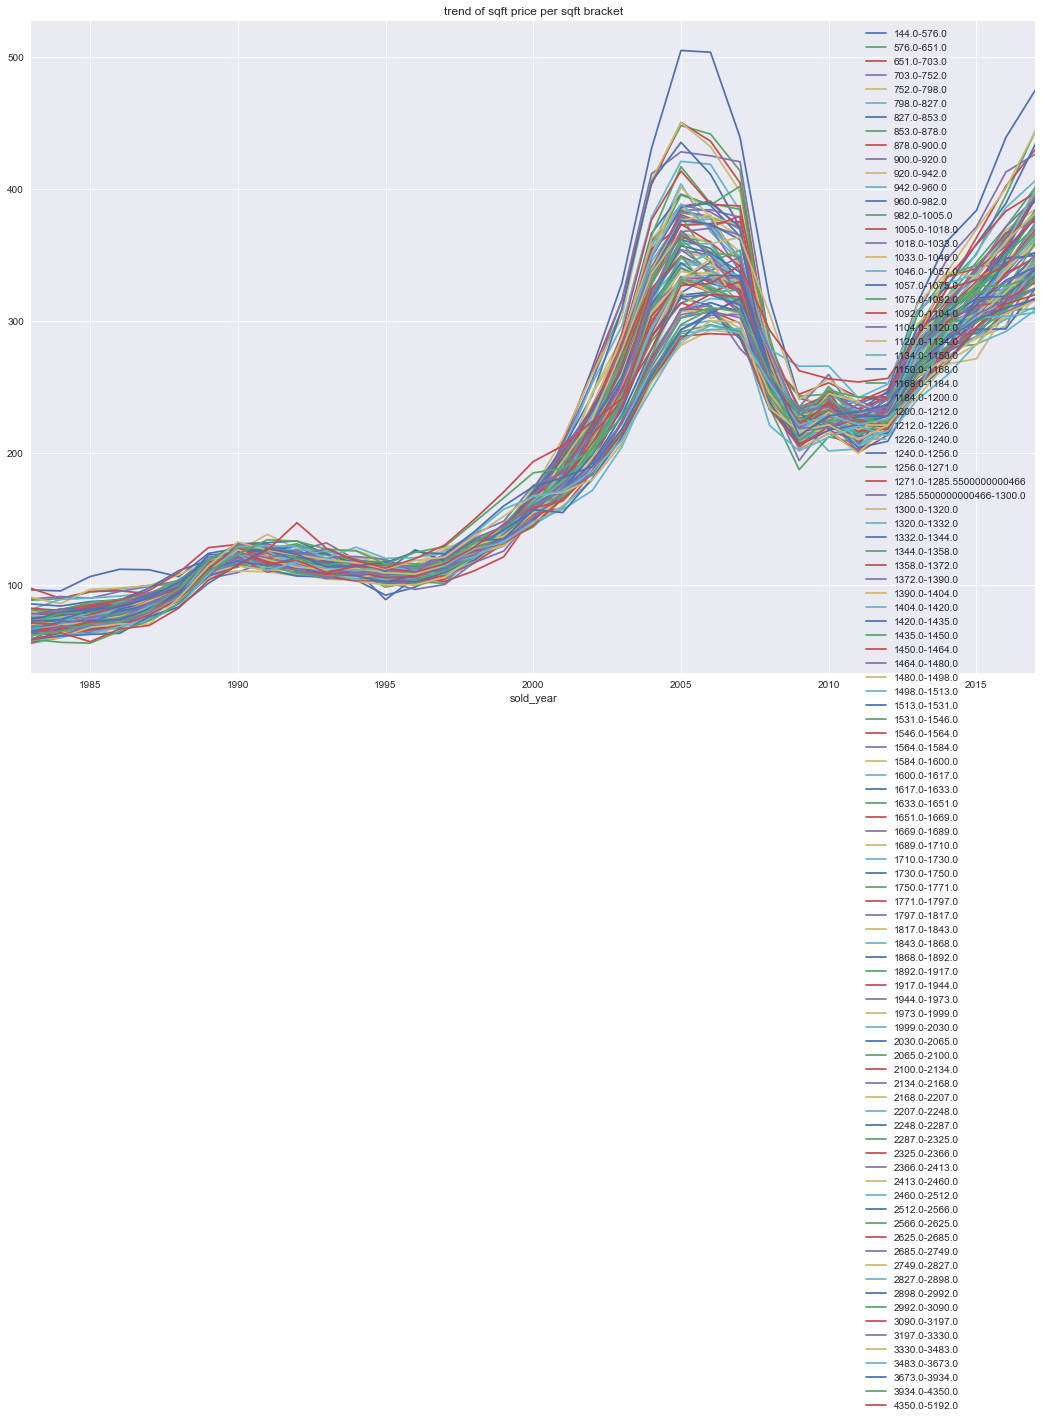

In [117]:
# segmented by sqft range
num_brackets = 100
sqft_segments = [df_all_valid['sqft'].quantile(i/num_brackets) for i in range(num_brackets)]

count = []
data = []
fig, ax = plt.subplots(figsize=(18,12))
for i in range(len(sqft_segments)-1):
    sqft_b,sqft_e = sqft_segments[i], sqft_segments[i+1]
    df_sqft_seg = df_all_valid[(df_all_valid['sqft']>=sqft_b) & (df_all_valid['sqft']<sqft_e)]
    
    bracket = df_sqft_seg.groupby(by=['sold_year'])['sqft_price']
    name = "{}-{}".format(sqft_b,sqft_e)
    #print(name, df_sqft_seg.shape[0])
    bracket_count = pd.Series(bracket.count(), name=name)
    count.append(bracket_count)
    df_sqft_seg = bracket.mean()
    data.append(pd.Series(df_sqft_seg, name=name))
    df_sqft_seg.plot(ax=ax, kind='line', label=name)
plt.legend(loc='best')
plt.title("trend of sqft price per sqft bracket")
plt.show()

df_heat = pd.concat(count, axis=1, keys=[s.name for s in count])
df_trend = pd.concat(data, axis=1)

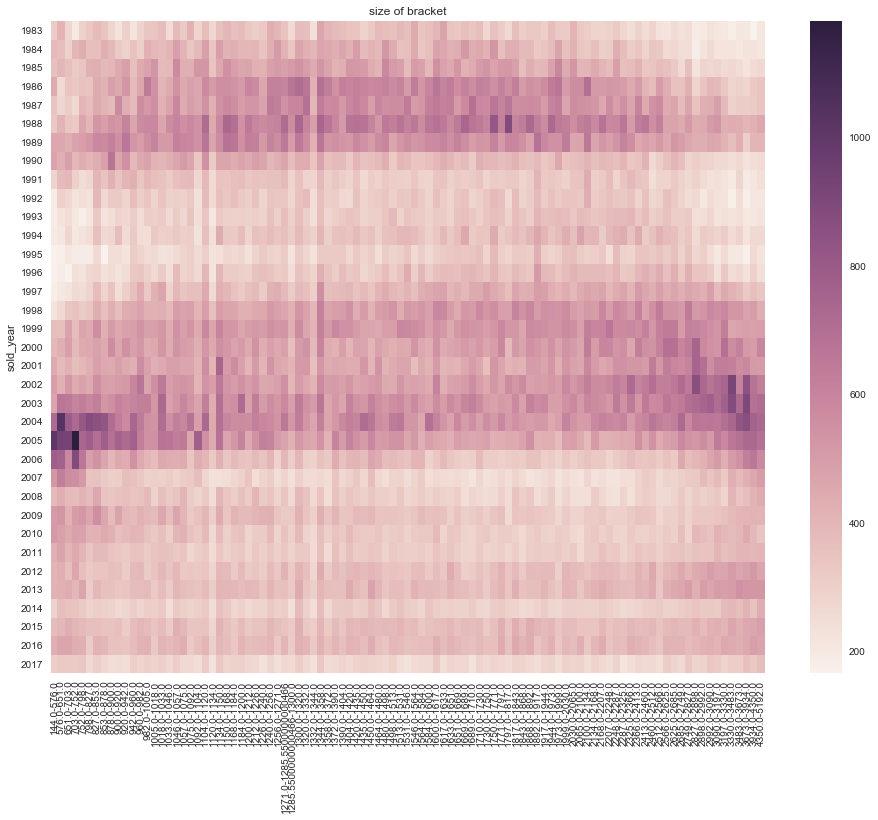

In [114]:
fig,ax = plt.subplots(figsize=(16,12))
ax.set_title('size of bracket')
hm = sns.heatmap(df_heat, ax=ax, annot=False, fmt="d")
plt.show()

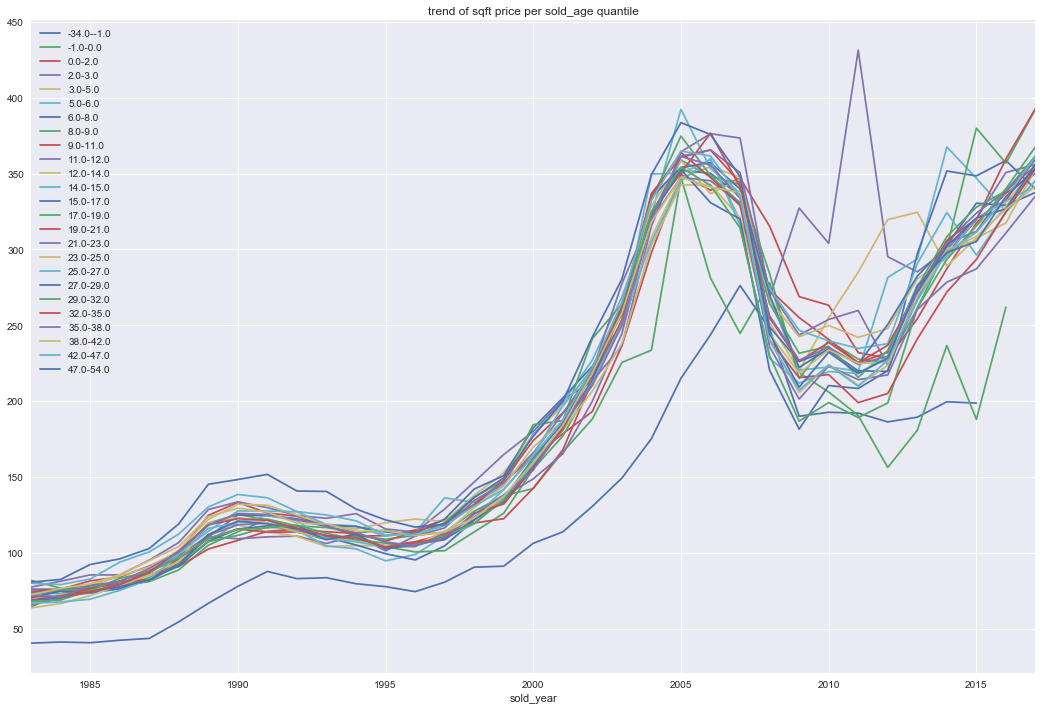

In [116]:
# bracket by sold_age
# NOTE: feature year_built is not clean, and same issue on sold_age

num_brackets = 30
year_segments = set([df_all_valid['sold_age'].quantile(i/num_brackets) for i in range(num_brackets)])
year_segments = sorted(list(year_segments))
count = []
data = []
fig, ax = plt.subplots(figsize=(18,12))
for i in range(len(year_segments)-1):
    year_b,year_e = year_segments[i], year_segments[i+1]
    df_year_seg = df_all_valid[(df_all_valid['sold_age']>=year_b) & (df_all_valid['sold_age']<year_e)]
    
    bracket = df_year_seg.groupby(by=['sold_year'])['sqft_price']
    name = "{}-{}".format(year_b,year_e)
    #print(name, df_year_seg.shape[0])
    bracket_count = pd.Series(bracket.count(), name=name)
    count.append(bracket_count)
    df_year_seg = bracket.mean()
    data.append(pd.Series(df_year_seg, name=name))
    df_year_seg.plot(ax=ax, kind='line', label=name)
plt.legend(loc='best')
plt.title("trend of sqft price per sold_age quantile")
plt.show()

df_heat_year = pd.concat(count, axis=1, keys=[s.name for s in count])
df_trend = pd.concat(data, axis=1)